# Models using only Time Series

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning')

import os
import time

import parkinson

import torch
from torch import nn

import pandas as pd
import networkx as nx
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32

## Data Processing
### Reading

In [4]:
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')

control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

100%|██████████| 66/66 [00:01<00:00, 42.31it/s]


In [5]:
control_ts_data = []

for idx_person in range(len(control_atlas_data)):
    person_ts = []

    for idx_region in range(len(control_atlas_data[idx_person].columns)):
        person_ts.append(list(control_atlas_data[idx_person].iloc[:,idx_region]))

    control_ts_data.append(person_ts)

In [6]:
parkinson_ts_data = []

for idx_person in range(len(parkinson_atlas_data)):
    person_ts = []

    for idx_region in range(len(parkinson_atlas_data[idx_person].columns)):
        person_ts.append(list(parkinson_atlas_data[idx_person].iloc[:,idx_region]))

    parkinson_ts_data.append(person_ts)

In [7]:
from imblearn.over_sampling import RandomOverSampler

X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])

X, y = parkinson.utils.data.filter_data(X, y)

X_2d = X.reshape(X.shape[0], -1)

ros = RandomOverSampler(random_state=RDN)
X_res, y_res = ros.fit_resample(X_2d, y)

X_res = X_res.reshape(-1, X.shape[1], X.shape[2])

X = X_res
y = y_res

### Split  
- 60% treino
- 20% validação
- 20% teste

In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

### Dataloaders

In [9]:
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

## Training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = parkinson.NetworkModels.tsMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
model = parkinson.NetworkModels.tsFCN(X_train.shape[1], N_CLASSES)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

In [11]:
model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [12]:
%%time
out = parkinson.utils.train.train(model, train_loader, val_loader, class_weights, device)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/miniconda3/envs/eniac/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.1120  train-acc: 0.9781 | val-loss: 0.5519  val-acc: 0.7869:  15%|█▌        | 30/200 [00:15<01:27,  1.93it/s]

Early stopping at epoch 31
CPU times: user 3 s, sys: 10.2 s, total: 13.2 s
Wall time: 16.2 s


In [13]:
val_loss = out['val_loss']

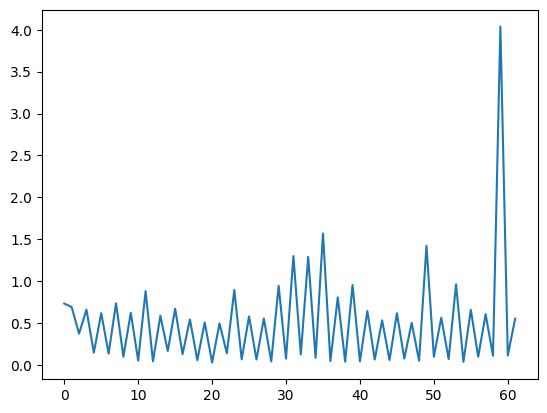

In [14]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(val_loss)), val_loss)

In [15]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)
print('Metrics:', metrics)
print('Done.')

Preds: [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Metrics: {'acc': 0.9354838709677419, 'f1': 0.93521421107628, 'recall': 0.9354838709677419, 'precision': 0.9428571428571428}
Done.
